<a href="https://colab.research.google.com/github/JangAyeon/Python_Machine_Learning/blob/main/%5B4_6%5DXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**파이썬 래퍼 XGBoost - 위스콘신 유방암 예측**

In [1]:
#XGBoost 버전 확인
import xgboost
print(xgboost.__version__)

0.90


**데이터 세트 로드**

In [20]:
import xgboost as xgb
from xgboost import plot_importance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score,roc_auc_score

import warnings
warnings.filterwarnings("ignore")


In [3]:
dataset=load_breast_cancer()
X_features=dataset.data
y_label=dataset.target

cancer_df=pd.DataFrame(data=X_features,columns=dataset.feature_names)
cancer_df["target"]=y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [4]:
print(dataset.target_names)
print(cancer_df["target"].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [5]:
#전체 data 중 80%는 train data, 20%는 test data
X_train,X_test,y_train,y_test=train_test_split(X_features,y_label,test_size=0.2,random_state=156)
print(X_train.shape,X_test.shape)

(455, 30) (114, 30)


**학습과 예측 데이터 세트를 DMatrix로 변환**

In [7]:
dtrain=xgb.DMatrix(data=X_train,label=y_train)
dtest=xgb.DMatrix(data=X_test,label=y_test)

**하이퍼 파라미터 설정**

In [8]:
params={"max_depth":3,
        "eta":0.1, #learning rate
        "objective":"binary:logistic", #결정 함수
        "eval_metric":"logloss", #손실에 대한 평가 함수
        "early_stopping":100}
num_rounds=400

**하이퍼 파라미터와 early stopping 파라미터를 train()에 전달하고 학습**

In [9]:
#train 데이터 셋은 "train", evaluation 데이터 셋은 "eval"로 표시
wlist=[(dtrain,"train"),(dtest,"eval")]
#하이퍼파라미터와 early stopping 파라미터를 train()함수와 파라미터로 전달
#num_boost_round는 n_estimator와 같은 의미
xgb_model=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_rounds,evals=wlist)

[0]	train-logloss:0.609688	eval-logloss:0.61352
[1]	train-logloss:0.540803	eval-logloss:0.547843
[2]	train-logloss:0.483753	eval-logloss:0.494248
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354146	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292593	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207938	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logloss:0.133985	eval-logloss:0.181818
[18]	train-logloss:0.125599	eval-logloss:0.174729
[19]	train-logloss:0.117286	eval-logloss:0.167657
[20]	train-logl

**prdict()로 예측 확률값 반환 -> 예측 값으로 변환**

In [10]:
pred_probs=xgb_model.predict(dtest)
print("predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨")
print(np.round(pred_probs[:10],3))
#예측 확률이 0.5보다 크면 1, 아니면 0으로 예측값 결정해서 list 객체인 preds에 저장
preds=[1 if x>0.5 else 0 for x in pred_probs]
print("예측값 10개만 표시: ",preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
예측값 10개만 표시:  [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [17]:
def get_clf_eval(y_test,pred=None,pred_proba=None):
  confusion=confusion_matrix(y_test,pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred)
  recall=recall_score(y_test,pred)
  f1=f1_score(y_test,pred)
  roc_auc=roc_auc_score(y_test,pred_proba)
  print("오차행렬")
  print(confusion)
  print("정확도: {0:.4f}, 정밀도:{1:.4f},재현율:{2:.4f}".format(accuracy,precision,recall))
  print("F1: {0:.4f}, AUC:{1:.4f}".format(f1,roc_auc))

In [18]:
get_clf_eval(y_test,preds,pred_probs)

오차행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도:0.9744,재현율:0.9870
F1: 0.9806, AUC:0.9951


**Feature Importance 시각화**

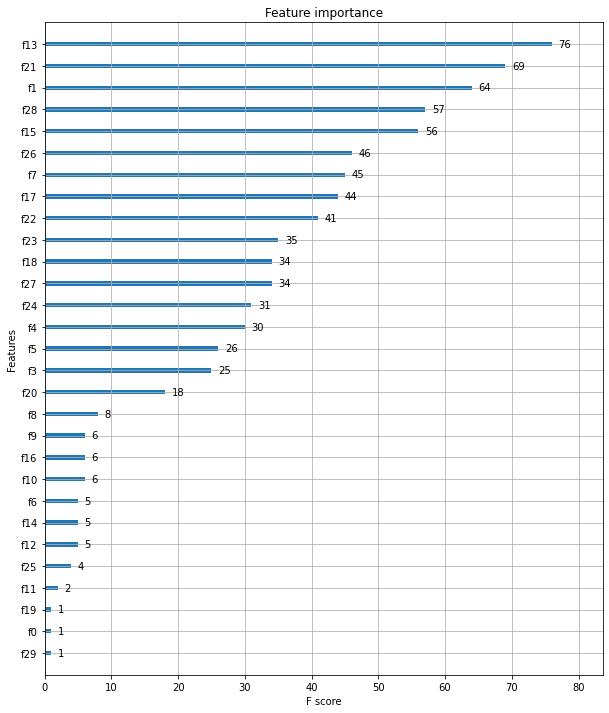

In [21]:
fig,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)

#**사이킷런 래퍼 XGBoost의 개요/적용**

In [23]:
from xgboost import XGBClassifier

In [25]:
evals=[(X_test,y_test)]

xgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)
xgb_wrapper.fit(X_train,y_train,
                early_stopping_rounds=400,
                eval_set=evals,eval_metric="logloss",verbose=True)

w_preds=xgb_wrapper.predict(X_test)
w_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 400 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

In [28]:
get_clf_eval(y_test,w_preds,w_pred_proba)

오차행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도:0.9744,재현율:0.9870
F1: 0.9806, AUC:0.9951


**Early Stopping을 100으로 설정 -> 재학습/예측/평가**

In [30]:
xgb_wrapper=XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)
evals=[(X_test,y_test)]
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric="logloss",eval_set=evals,verbose=True)

ws100_preds=xgb_wrapper.predict(X_test)
ws100_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

In [31]:
get_clf_eval(y_test,ws100_preds,ws100_pred_proba)

오차행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도:0.9620,재현율:0.9870
F1: 0.9744, AUC:0.9954


**Early Stopping을 10으로 설정 -> 재학습/예측/평가**

In [32]:
xgb_wrapper.fit(X_train,y_train,
                early_stopping_rounds=10,
                eval_metric="logloss",eval_set=evals,verbose=True)

ws10_preds=xgb_wrapper.predict(X_test)
ws10_pred_proba=xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test,ws100_preds,ws10_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


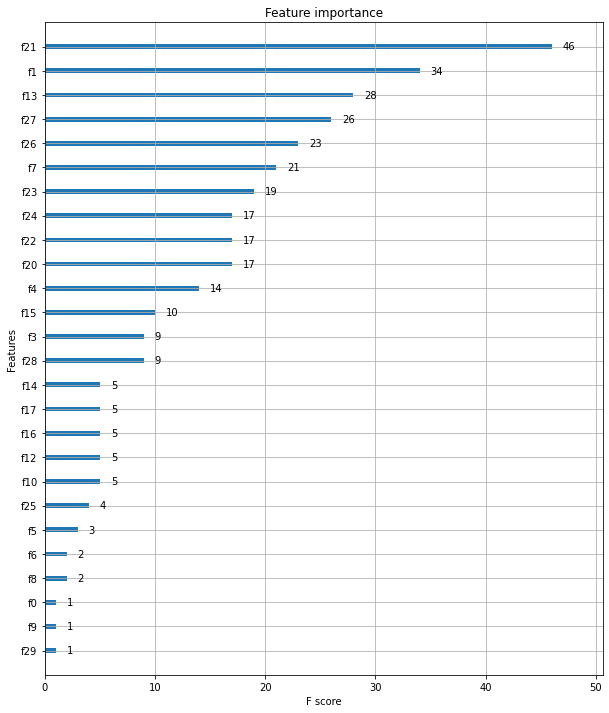

In [34]:
fig,ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper,ax=ax)